<a href="https://colab.research.google.com/github/ibonetc/AI_Deep-Learning/blob/main/GAN_pix2pix_Example_Retina_PNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pix2pix: Image-to-image translation with a conditional GAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ejemplo tomado del tutorial: https://www.tensorflow.org/tutorials/generative/pix2pix

Acá construimos una red tutorial demuestra cómo construir y entrenar una red antagónica generativa condicional (cGAN, conditional generative adversarial network) llamada pix2pix. Esta es otra red de la gama de redes GAN, que aprende un mapeo de imágenes de entrada a imágenes de salida.

pix2pix no es una aplicación específica: se puede aplicar a una amplia gama de tareas, incluida la síntesis de fotos a partir de mapas de etiquetas, la generación de fotos coloreadas a partir de imágenes en blanco y negro, la conversión de fotos de Google Maps en imágenes aéreas e incluso la transformación de bocetos en fotos.

En este ejemplo, su red generará imágenes de fachadas de edificios utilizando la base de datos de fachadas CMP proporcionada por el Centro de Percepción de Máquinas de la Universidad Técnica Checa en Praga . Para abreviar, utilizará una copia preprocesada de este conjunto de datos creado por los autores de pix2pix.

En pix2pix cGAN, usted condiciona las imágenes de entrada y genera las imágenes de salida correspondientes.

La arquitectura de su red contendrá:

*  Un generador con una arquitectura basada en U-Net .
*  Un discriminador representado por un clasificador PatchGAN convolucional (propuesto en el artículo de pix2pix ).

A continuación se muestran algunos ejemplos de la salida generada por pix2pix cGAN después de entrenar durante 100 épocas en el conjunto de datos de fachadas (pasos de 80k).


![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Importar TensorFlow y otras bibliotecas

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
from glob import glob
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle

## Cargar la base de datos

Utilizaremos los datos de retina de la base de datos DRIVE

In [ ]:
!unzip '/content/drive/MyDrive/Data_AI/Drive.zip'

Archive:  /content/drive/MyDrive/Data_AI/Drive.zip
   creating: Drive/
   creating: Drive/test/
   creating: Drive/test/image/
 extracting: Drive/test/image/0.png  
 extracting: Drive/test/image/1.png  
 extracting: Drive/test/image/10.png  
 extracting: Drive/test/image/11.png  
 extracting: Drive/test/image/12.png  
 extracting: Drive/test/image/13.png  
 extracting: Drive/test/image/14.png  
 extracting: Drive/test/image/15.png  
 extracting: Drive/test/image/16.png  
 extracting: Drive/test/image/17.png  
 extracting: Drive/test/image/18.png  
 extracting: Drive/test/image/19.png  
 extracting: Drive/test/image/2.png  
 extracting: Drive/test/image/3.png  
 extracting: Drive/test/image/4.png  
 extracting: Drive/test/image/5.png  
 extracting: Drive/test/image/6.png  
 extracting: Drive/test/image/7.png  
 extracting: Drive/test/image/8.png  
 extracting: Drive/test/image/9.png  
   creating: Drive/test/mask/
  inflating: Drive/test/mask/0.png   
  inflating: Drive/test/mask/1.png 

In [ ]:
image = tf.io.read_file('/content/Drive/train/image/0.png')
image = tf.io.decode_jpeg(image)
input_image = tf.cast(image, tf.float32)

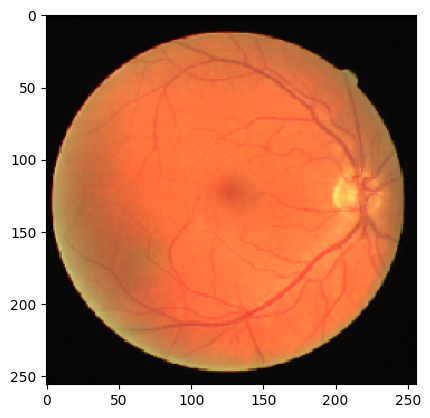

In [ ]:
plt.figure()
plt.imshow(image)

Cambiar el tamaño de la imagen

In [ ]:
height=256
width=256
input_image = tf.image.resize(input_image, [height, width],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

Normalizar la imagen entre [-1,1]

In [ ]:
input_image = (input_image / 127.5) - 1

Función para cargar las imágenes con todas estas transformaciones

In [ ]:
def load_image(file, H=256, W=256):
  image = tf.io.read_file('/content/Drive/train/image/0.png')
  image = tf.io.decode_jpeg(image)
  input_image = tf.cast(image, tf.float32)
  input_image = tf.image.resize(input_image, [H, W],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  input_image = (input_image / 127.5) - 1
  return input_image

In [ ]:
def load_path(path):
  x = sorted(glob(os.path.join(path, "image", "*.png")))
  y = sorted(glob(os.path.join(path, "mask", "*.png")))

In [ ]:
def tf_parse(x, y):
  def _parse(x, y):
      x = load_image(x)
      y = load_image(y)
      return x, y

  x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
  x.set_shape([H, W, 3])
  y.set_shape([H, W, 1])
  return x, y

Construir los datos de entrada

In [ ]:
# 20 images in training set
BUFFER_SIZE = 20
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

In [ ]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = (x / 127.5) - 1
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = (x / 127.5) - 1
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
def load_image(path):
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (W, H))
  x = (x / 127.5) - 1
  x = x.astype(np.float32)
  return x

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
dataset_path = "/content/Drive"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

In [ ]:
train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
test_x, test_y = load_data(test_path)

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch_size=BATCH_SIZE)
test_dataset = tf_dataset(test_x, test_y, batch_size=BATCH_SIZE)
train_steps = len(train_x)//BATCH_SIZE
test_setps = len(test_x)//BATCH_SIZE

if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1
if len(test_x) % BATCH_SIZE != 0:
    test_setps += 1

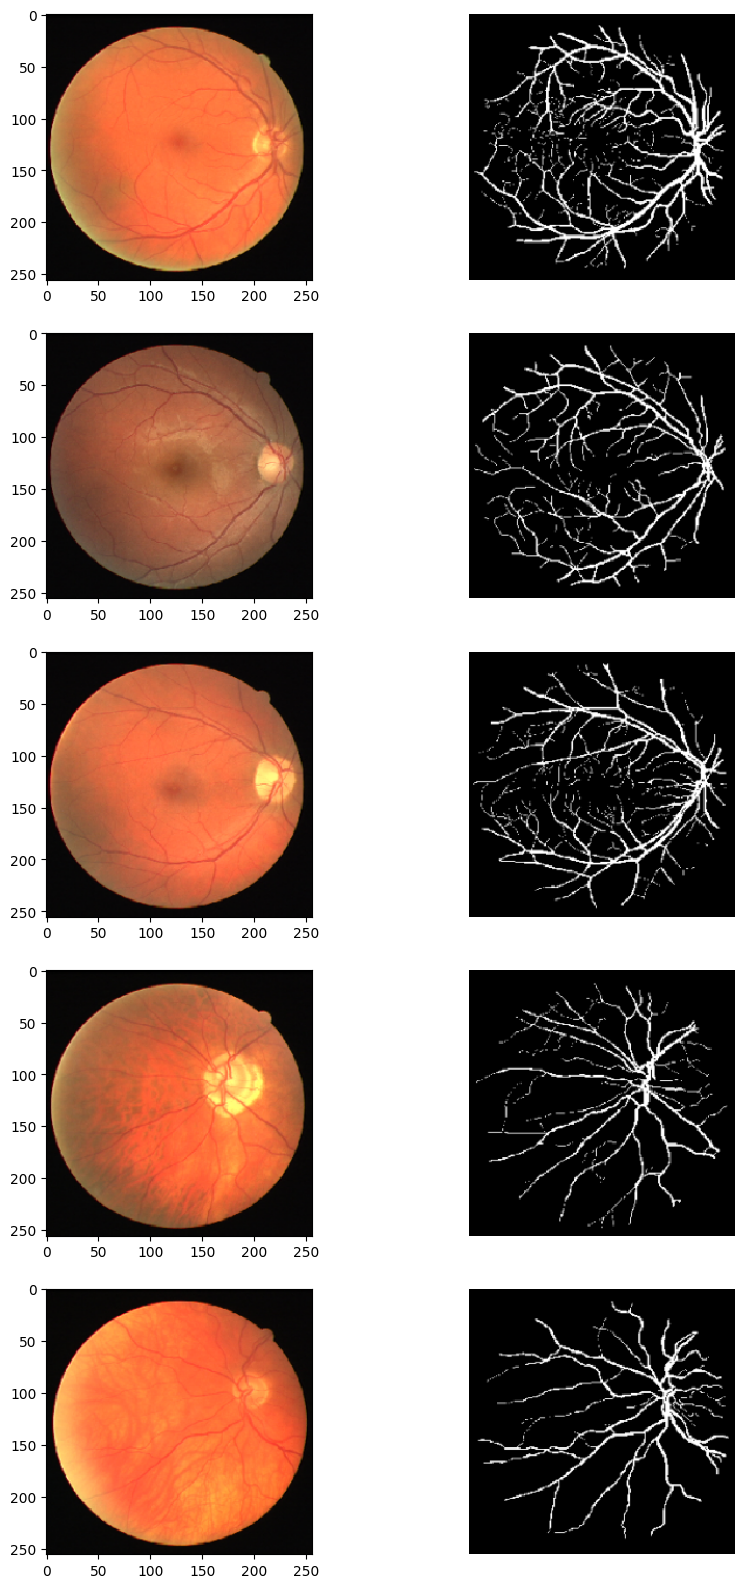

In [ ]:
plt.figure(figsize=(10, 20))
for i,index in enumerate(range(21,26)):
  image=cv2.imread("/content/Drive/train/image/{}.png".format(i), cv2.IMREAD_COLOR)
  mask=cv2.imread('/content/Drive/train/mask/{}.png'.format(i), cv2.IMREAD_GRAYSCALE)
  plt.subplot(5, 2, (i+1)*2 -1)
  plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  plt.subplot(5, 2, (i+1)*2)
  plt.imshow(cv2.cvtColor(mask,cv2.COLOR_BGR2RGB))
  plt.axis('off')
plt.show()

## Construye el generador

El generador de tu pix2pix cGAN es una red U-Net modificada.


Definir el downsampler (codificador):

In [ ]:
OUTPUT_CHANNELS = 1

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Definir el upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Defina el generador con el codificador y decodificador con entradas 256x256:

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualice la arquitectura del modelo del generador:

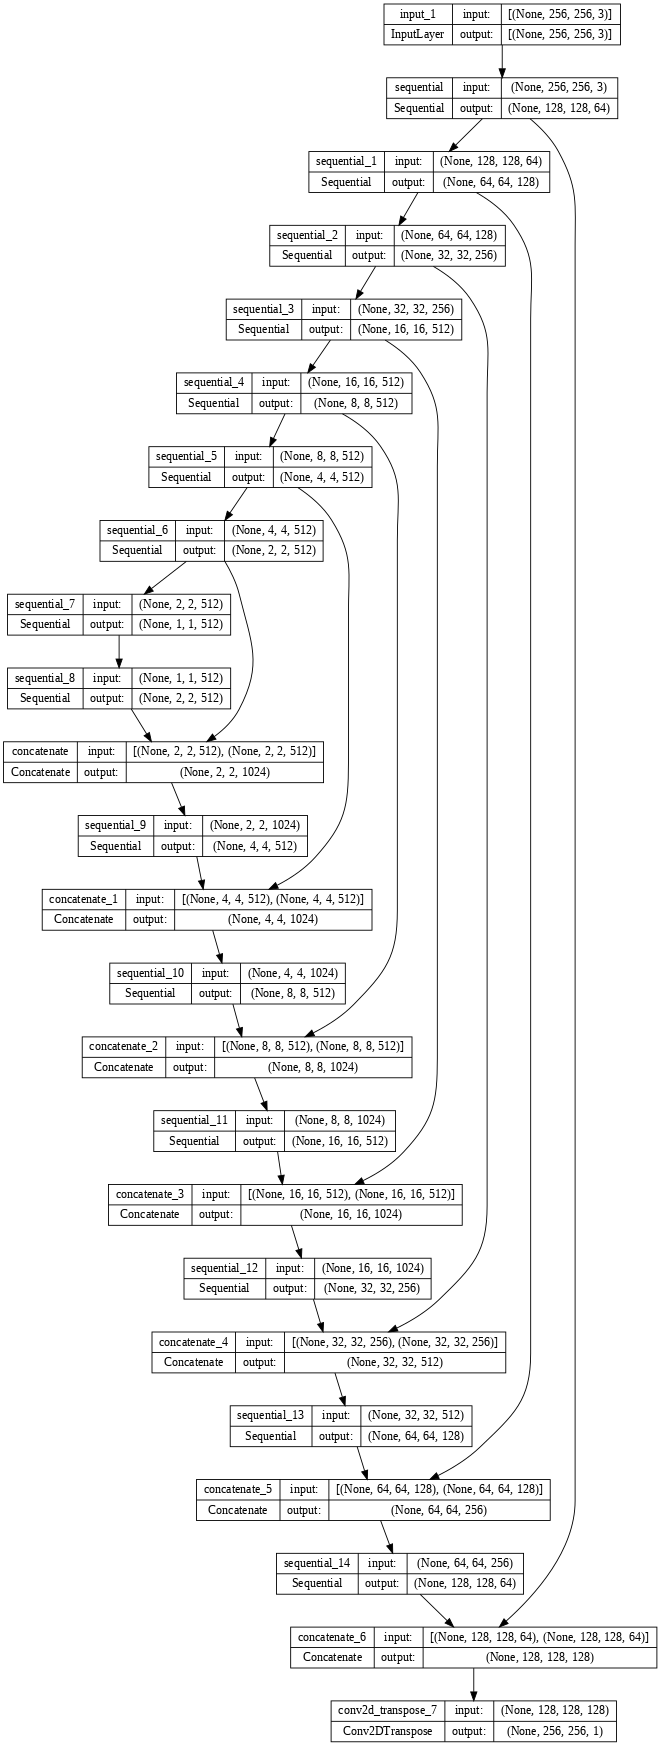

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Definir la pérdida del generador

Las GAN aprenden una pérdida que se adapta a los datos, mientras que las cGAN aprenden una pérdida estructurada que penaliza una posible estructura que difiere de la salida de la red y la imagen de destino, como se describe en el artículo de pix2pix .

La pérdida del generador es una pérdida de entropía cruzada sigmoidea de las imágenes generadas y una matriz de unos.

El artículo de pix2pix también menciona la pérdida L1, que es un MAE (error absoluto medio) entre la imagen generada y la imagen de destino.
Esto permite que la imagen generada se vuelva estructuralmente similar a la imagen de destino.
La fórmula para calcular la pérdida total del generador es gan_loss + LAMBDA * l1_loss , donde LAMBDA = 100 . Este valor fue decidido por los autores del artículo.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Construcción del discriminador

El discriminador en pix2pix cGAN es un clasificador PatchGAN convolucional: intenta clasificar si cada parche de imagen es real o no, como se describe en el artículo de pix2pix .

Cada bloque en el discriminador es: Convolución -> Normalización de lotes -> Leaky ReLU.
La forma de la salida después de la última capa es (batch_size, 30, 30, 1) .
Cada parche de imagen de 30 x 30 de la salida clasifica una porción de 70 x 70 de la imagen de entrada.
El discriminador recibe 2 entradas:
La imagen de entrada y la imagen de destino, que debe clasificar como real.
La imagen de entrada y la imagen generada (la salida del generador), que debe clasificar como falsa.
Use tf.concat([inp, tar], axis=-1) para concatenar estas 2 entradas juntas.


Definamos el discriminador:



In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualizar la arquitectura del modelo discriminador:

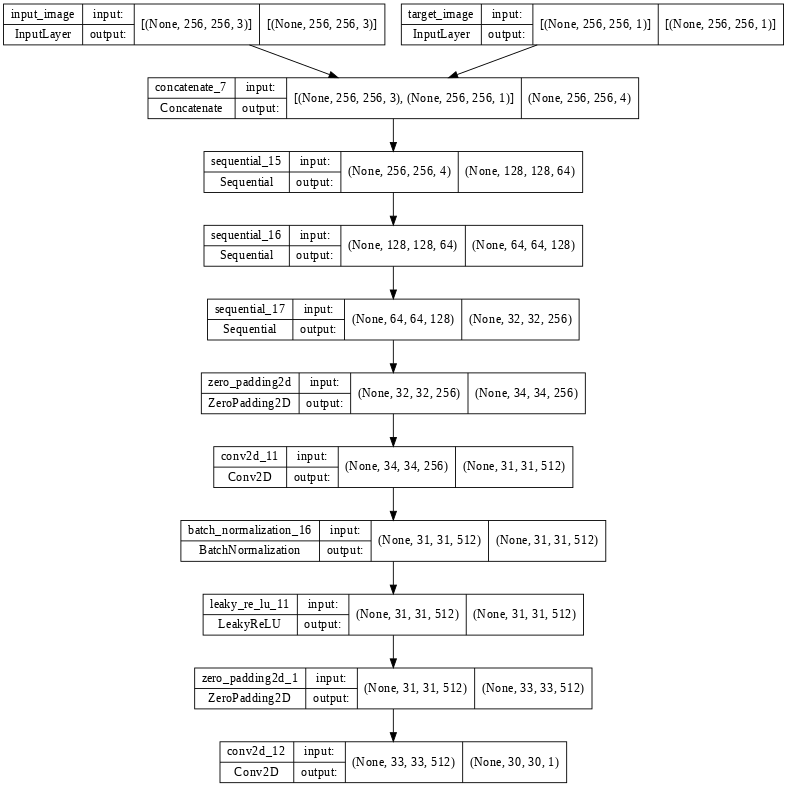

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

### Definir la pérdida del discriminador
La función discriminator_loss toma 2 entradas: imágenes reales e imágenes generadas.

**real_loss** es una pérdida de entropía cruzada sigmoidea de las imágenes reales y una matriz de unas (ya que estas son las imágenes reales).

La pérdida** generated_loss** es una pérdida de entropía cruzada sigmoidea de las imágenes generadas y una matriz de ceros (ya que estas son las imágenes falsas).

La total_loss es la suma de la real_loss y la generated_loss .

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Definir los optimizadores y un punto de control de ahorro


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generar imágenes

Escribe una función para trazar algunas imágenes durante el entrenamiento.

Pase imágenes del equipo de prueba al generador.
El generador luego traducirá la imagen de entrada a la salida.

El último paso es trazar las predicciones

In [ ]:
example_input, example_target = next(iter(test_dataset.take(1)))

In [ ]:
prediction = generator(example_input, training=True)
input=example_input[0]
output=example_target[0]

In [ ]:
input.shape

TensorShape([256, 256, 3])

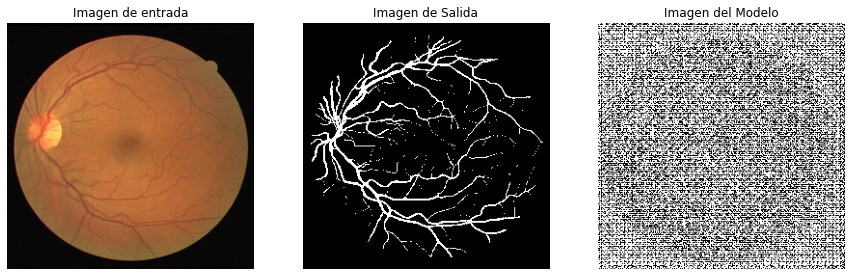

In [ ]:
plt.figure(figsize=(15, 15))
y_pred=prediction[0]
y_pred = (y_pred * 0.5 + 0.5) > 0.5
y_pred = np.squeeze(y_pred, axis=-1)

y=example_target[0]
y = (y * 0.5 + 0.5) > 0.5
y = np.squeeze(y, axis=-1)

display_list = [example_input[0]* 0.5 + 0.5, y, y_pred]
title = ['Imagen de entrada', 'Imagen de Salida', 'Imagen del Modelo']
plt.subplot(1, 3, 1)
plt.title(title[0])
plt.imshow(cv2.cvtColor(display_list[0].numpy(),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title(title[1])
plt.imshow(display_list[1], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title(title[2])
plt.imshow(display_list[2], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  y_pred=prediction[0]
  y_pred = (y_pred * 0.5 + 0.5) > 0.5
  y_pred = np.squeeze(y_pred, axis=-1)

  y=tar[0]
  y = (y * 0.5 + 0.5) > 0.5
  y = np.squeeze(y, axis=-1)

  display_list = [test_input[0]* 0.5 + 0.5, y, y_pred]
  title = ['Imagen de entrada', 'Imagen de Salida', 'Imagen del Modelo']
  plt.subplot(1, 3, 1)
  plt.title(title[0])
  plt.imshow(cv2.cvtColor(display_list[0].numpy(),cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.title(title[1])
  plt.imshow(display_list[1], cmap='gray')
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.title(title[2])
  plt.imshow(display_list[2], cmap='gray')
  plt.axis('off')
  plt.show()

## Entrenamiento

Para cada ejemplo, la entrada genera una salida.

El discriminador recibe input_image y la imagen generada como primera entrada. La segunda entrada es input_image y target_image.

A continuación, calcule el generador y la pérdida del discriminador.

Luego, calcule los gradientes de pérdida con respecto tanto al generador como a las variables discriminadoras (entradas) y aplíquelas al optimizador.

Finalmente, registre las pérdidas en TensorBoard.

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

El ciclo de entrenamiento real. Dado que este tutorial puede ejecutarse en más de un conjunto de datos, y los conjuntos de datos varían mucho en tamaño, el ciclo de entrenamiento está configurado para funcionar en pasos en lugar de épocas.

Itera sobre el número de pasos.

Cada 10 pasos imprime un punto ( . ).

Cada 1k pasos: borre la pantalla y ejecute generate_images para mostrar el progreso.

Cada 5k pasos: guarda un punto de control.

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'El paso {step} demoró: {time.time()-start:.2f} segundos\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Paso: {step//1000}k")

    train_step(input_image, target, step)

    # Paso de entrenamiento
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Entrenamiento:

El paso 1000 demoró: 232.30 segundos



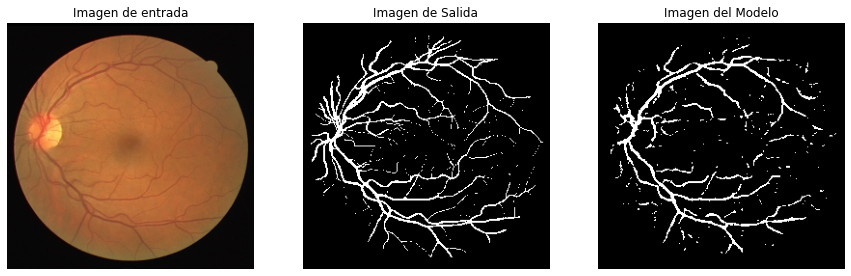

Paso: 1k
....................................................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=2000)

Si desea compartir los resultados de TensorBoard públicamente , puede cargar los registros en TensorBoard.dev copiando lo siguiente en una celda de código.
Nota: Esto requiere una cuenta de Google.

```
!tensorboard dev upload --logdir {log_dir}
```

**Precaución**: Este comando no termina. Está diseñado para cargar continuamente los resultados de experimentos de larga duración. Una vez que se cargan sus datos, debe detenerlos usando la opción "interrumpir ejecución" en su herramienta de cuaderno.

Puede ver los resultados de una ejecución anterior de este cuaderno en TensorBoard.dev.

TensorBoard.dev es una experiencia administrada para hospedar, rastrear y compartir experimentos de ML con todos.

También se puede incluir en línea usando un <iframe> :

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

## Generar algunas imágenes usando el conjunto de prueba

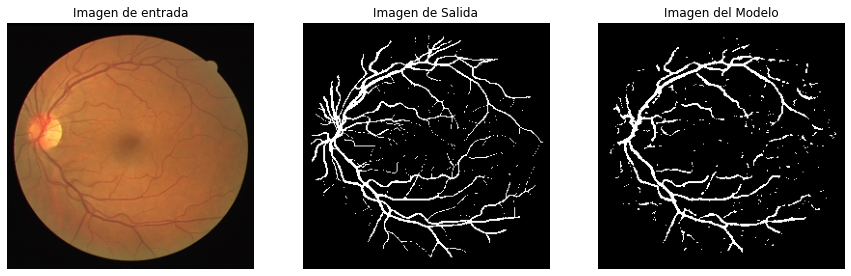

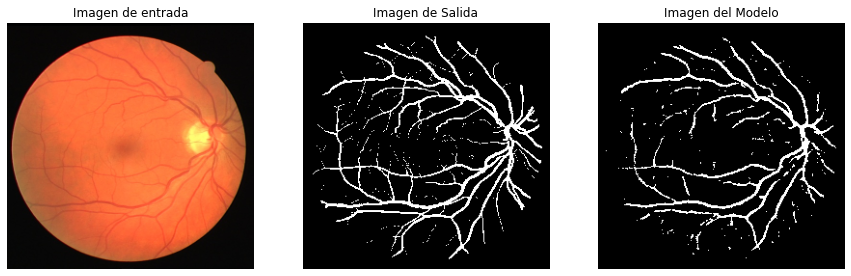

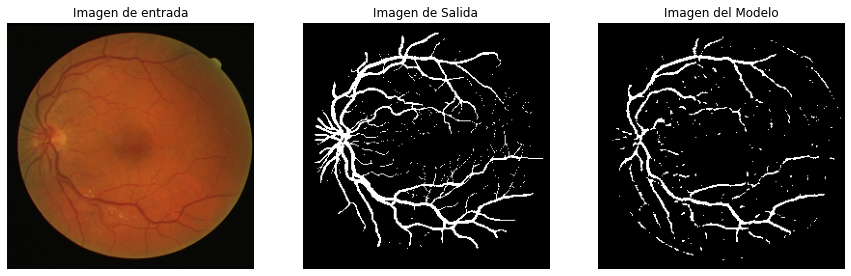

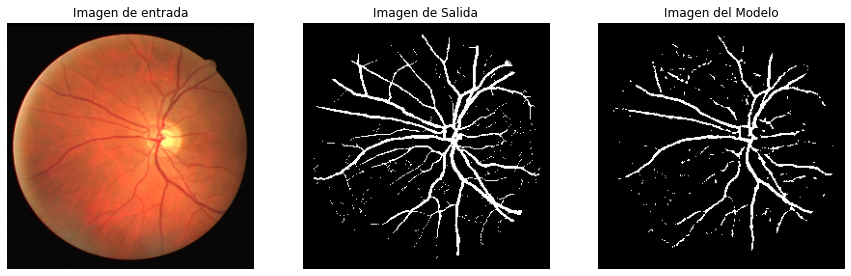

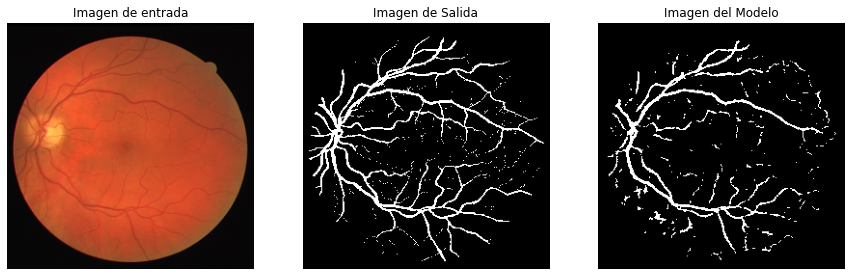

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)